In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from astropy.cosmology import FlatLambdaCDM

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI

In [2]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/'
filename = 'all_data_sim.csv'
data = pd.read_csv(path + filename)
data.head()

,COADD_OBJECT_ID,PIXEL,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I
0,236335206,77814339,327.919350,-2.428228,0.117966,0.210426,0.525545,331.45166,1.25844,0.939833,0.877707
1,70545489,78067927,331.595251,1.728539,-0.048398,0.025056,0.670143,292.97107,1.18560,0.997701,0.967877
2,273414698,73623631,11.680589,-2.547385,0.040328,-0.009064,0.296297,230.58035,1.23382,0.961234,0.813862
3,97958268,77220874,341.685203,-0.561310,0.169910,-0.003900,0.513382,161.21182,1.16274,0.913424,0.833242
4,210507700,78204227,325.113246,-0.342198,-0.026240,0.403285,0.593909,248.81100,1.21352,0.950123,0.861977


In [3]:
numpix = 46
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }
DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [4]:
Einstein = []
for index, row in data.iterrows():
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [row['Z']],  # list of redshift of the deflections
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [0.67, 0.8],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': 0.8} 
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    
    angle, ratio = param.ellipticity2phi_q(row['SOF_CM_G_1'], row['SOF_CM_G_2'])
    angle += 0.698132*random.uniform(-1, 1) #noise between -40 and 40 degrees
    ratio = random.uniform(0.001, 1) #distribution for the axis ratio
    e1, e2 = param.phi_q2_ellipticity(angle, ratio)
    
    kwargs_mass = [{'sigma_v': row['VEL_DISP'], 'center_x': 0, 'center_y': 0, 
                    'e1': e1, 'e2': e2}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    Einstein.append(kwargs_lens[0]['theta_E'])

In [5]:
data['THETA_E'] = Einstein
data.head()

,COADD_OBJECT_ID,PIXEL,RA,DEC,SOF_CM_G_1,SOF_CM_G_2,Z,VEL_DISP,FWHM_WMEAN_G,FWHM_WMEAN_R,FWHM_WMEAN_I,THETA_E
0,236335206,77814339,327.919350,-2.428228,0.117966,0.210426,0.525545,331.45166,1.25844,0.939833,0.877707,0.927515
1,70545489,78067927,331.595251,1.728539,-0.048398,0.025056,0.670143,292.97107,1.18560,0.997701,0.967877,0.328079
2,273414698,73623631,11.680589,-2.547385,0.040328,-0.009064,0.296297,230.58035,1.23382,0.961234,0.813862,0.883859
3,97958268,77220874,341.685203,-0.561310,0.169910,-0.003900,0.513382,161.21182,1.16274,0.913424,0.833242,0.229999
4,210507700,78204227,325.113246,-0.342198,-0.026240,0.403285,0.593909,248.81100,1.21352,0.950123,0.861977,0.384349


Total Number of Galaxies: 19727


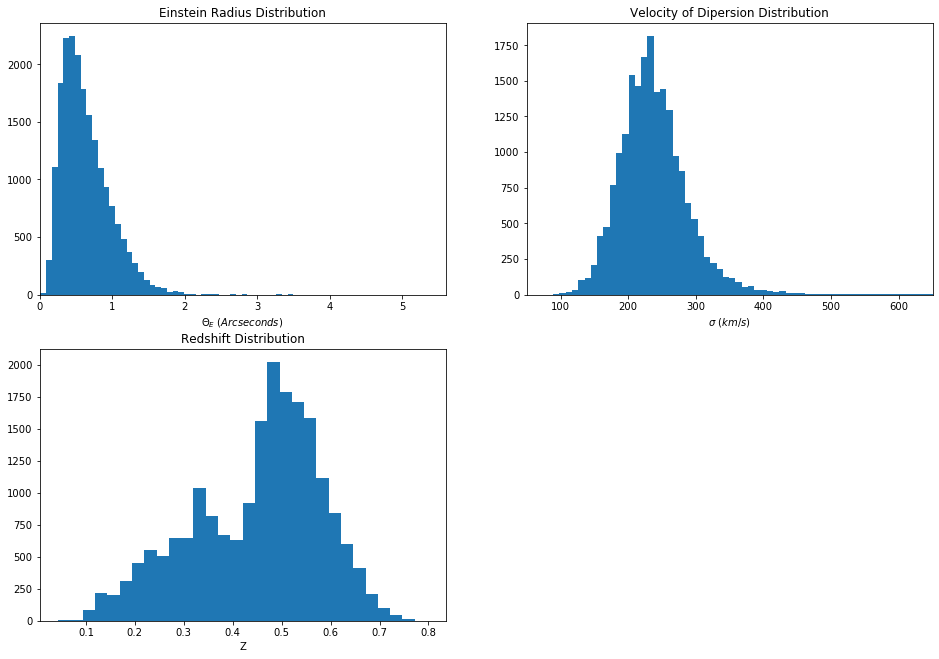

In [8]:
print('Total Number of Galaxies: ' + str(len(data)))

plt.figure(figsize=(16,11))

plt.subplot(2, 2, 1)
plt.hist(data['THETA_E'], 80)
plt.title('Einstein Radius Distribution')
plt.xlabel(r'$\Theta_E\ (Arc seconds)$')
plt.xlim(0,5.6)

plt.subplot(2, 2, 2)
plt.hist(data['VEL_DISP'], 80)
plt.title('Velocity of Dipersion Distribution')
plt.xlabel(r'$\sigma\ (km/s)$')
plt.xlim(50, 650)

plt.subplot(2, 2, 3)
plt.hist(data['Z'], 30)
plt.title('Redshift Distribution')
plt.xlabel('Z')

plt.show()

In [9]:
# Cutout size ~12 arc seconds
data_cut = data[data['THETA_E'] >= 0.4]
print(len(data))
print(len(data_cut))

19727
14398
